# Homework 6

In this homework you will be training and using a "char-RNN". This is the name given to a character-level recurrent neural network language model by [this famous blog post by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Before you start on the rest of the homework, please give the blog post a read, it's quite good!

I don't expect you to implement the char-RNN from scratch. Andrej's original char-rnn is in Torch (the predecessor to PyTorch that is not commonly used anymore). Fortunately, there are many other implementations of this model available; for example, there is one (in both mxnet and pytorch) in chapters 8 and 9 of [the textbook](http://d2l.ai), and another pytorch one [here](https://github.com/spro/char-rnn.pytorch). **Please use one of these example implementations (or another one that you find) when completing this homework**.

For this homework, please complete the following steps:

1. Download and tokenize the [Shakespeare dataset](http://www.gutenberg.org/files/100/100-0.txt) at a character level. I recommend basing your solution on the following code:
```Python
# Remove non-alphabetical characters, lowercase, and replace whitespace with ' '
raw_dataset = ' '.join(re.sub('[^A-Za-z ]+', '', text).lower().split())
# Maps token index to character
idx_to_char = list(set(raw_dataset))
# Maps character to token index
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
# Tokenize the dataset
corpus_indices = [char_to_idx[char] for char in raw_dataset]
```
1. Train a "vanilla" RNN (as described in chapter 9 of [the textbook](http://d2l.ai)) on the Shakespeare dataset. Report the training loss and generate some samples from the model at the end of training.
1. Train a GRU RNN (as described in chapter 10 of [the textbook](http://d2l.ai)) on the Shakespeare datatset. Is the final training loss higher or lower than the vanilla RNN? Are the samples from the model more or less realistic?
1. Find a smaller, simpler dataset than the Shakespeare data (you can find some ideas in Andrej's blog post, but feel free to get creative!) and train either the vanilla or GRU RNN on it instead. Is the final training loss higher or lower than it was for the Shakespeare data?

# Summary of my work:

Most of my implementations as well as the tokenization process are based on [this repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb).
The tokenization process is at character level and uses the mapping from the string module. I decided to go with this and not the tokenization advised because I wanted to keep a case-sensitive model and line breaks so that the generated text would also come in a theater play format. However, I generalized some helper functions to use them on both the Shakespeare dataset and the dataset I have chosen for q.4, a dinosaur names dataset. The GRU model is fully based on the version in the mentioned above repo, and I adapted it for the Vanilla RNN one. In order to compare them (training loss and samples realisticness), I used the same learning rate, number of epochs and length of generation sample, and the batch size here is 1 as we're not aiming for any particular performance but the loss, so we will plot the average loss to check its evolution. Results will be discussed under each specific section.

# 1. Imports, helper functions and tokenization

In [1]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.6 MB/s eta 0:00:00


In [2]:
#Module imports
import unidecode
import string
import random
import time
import math
import tqdm
import numpy as np
import argparse
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

In [3]:
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_characters = string.printable
n_characters = len(all_characters)

In [4]:
#Some useful general-purpose functions

#Computes elapsed time
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#Reads a file from the given filepath, replaces characters in replace_list and cuts all characters before start_char
def read_file(filename,replace_list, start_char):
    file = unidecode.unidecode(open(filename).read())
    file = file[start_char:]
    for x,y in replace_list:
      file = file.replace(x,y)
    return file, len(file)

#Tokenizes a given input string at character-level with the string module mapping
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

#Outputs a random string chunk of lenght chunk_len from the dataset
def random_chunk(raw_dataset, dataset_len, chunk_len):

    start_index = random.randint(0, dataset_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return raw_dataset[start_index:end_index]

#Outputs the tensor input and target from a random chunk computed above
def random_training_set_chunky(raw_dataset, dataset_len, chunk_len):
    chunk = random_chunk(raw_dataset,dataset_len,chunk_len)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

#Outputs a random string dinosaur name
def random_dino_name(raw_dataset):
    return random.choice(raw_dataset)

#Outputs input and target tensor from a random dinosaur name
def random_training_set_dino(raw_dataset):
    name = random_dino_name(raw_dataset)
    inp = char_tensor(name[:-1])
    target = char_tensor(name[1:])
    return inp, target

In [5]:
def generate(model, prime_str='A', predict_len=200, temperature=0.8):

    hidden = model.init_hidden(1).to(device)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0)).to(device)
    predicted = prime_str

    #Build the hidden state from all characters in prime_str
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[:, p], hidden)
    inp = prime_input[:,-1]

    #Generate from the last character in prime_str and the hidden state built using prime_str
    for p in range(predict_len):
        output, hidden = model(inp, hidden)

        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0)).to(device)

    return predicted

In [6]:
def evaluate(model, prime_str='A', predict_len=200, temperature=0.8):
    hidden = model.init_hidden().to(device)
    prime_input = char_tensor(prime_str).to(device)
    predicted = prime_str

    #Build the hidden state from all characters in prime_str
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]

    #Generate from the last character in prime_str and the hidden state built using prime_str
    for p in range(predict_len):
        output, hidden = model(inp, hidden)

        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char).to(device)

    return predicted

In [7]:
def train(model, inp, target, chunk_len):
    hidden = model.init_hidden().to(device)
    model.zero_grad()
    loss = 0
    inp, target = inp.to(device), target.to(device)

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output[0], target[c])

    loss.backward()
    model_optimizer.step()

    return loss.item() / chunk_len

In [8]:
#Vanilla RNN implemention adapted from this GRU one : https://github.com/spro/char-rnn.pytorch
class Vanilla_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Vanilla_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [9]:
#GRU RNN implemention based on https://github.com/spro/char-rnn.pytorch
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# 2. Vanilla RNN training

In [ ]:
#Pre-processing the dataset, removing useless characters before the real Shakespeare sonnets
start_char = 2252
replace_list = [('\n\n                    ','\n\n ')]

raw_dataset_shakespeare, dataset_len_shakespeare = read_file('shakespeare.txt', replace_list, start_char)

chunk_len = 200

n_epochs = 15000
print_every = 5000
plot_every = 200
hidden_size = 100
n_layers = 1
lr = 0.005

In [ ]:
model = Vanilla_RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_vanilla = []
loss_avg = 0

In [ ]:
for epoch in range(1, n_epochs + 1):

    loss = train(model, *random_training_set_chunky(raw_dataset_shakespeare, dataset_len_shakespeare,chunk_len), chunk_len)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, random.sample(all_characters[36:62],1)[0], 200), '\n')

    if epoch % plot_every == 0:
        all_losses_vanilla.append(loss_avg / plot_every)
        loss_avg = 0

 12s (5000 33%) 2.1884]
U!
O am a jeates wing and love of to time of on,
Thou would you horsh and ation with me if captase the love his rom how cames, hear pure you loot and out this king her, he was promun,
And blind hit it  

 9s (10000 66%) 1.9689]
LAFF.
Why contard. See hang theyer weedithrafter hides, and not foud. The enton; if sconthant here would it in such you stgence with med,
'Tis warnow one there lifter heave of me; I war ald with beilou 

 54s (15000 100%) 1.8734]
Y.
[_Asive-soubse lion reed
And servee,
Band that lean.--ing ume:
As be upir of bear let the fath no have cirse of all rriend. And gare's a marnet you, mistre the house,
a worthou, for cand'd the spart 



In [ ]:
print(evaluate(model, 'T', 200))

Than the presend, what death; he and your like I good the down this mild of you, and god them not the make a vucken this most noble huse the rear emphose exter granging what and beswereford,
Come the c


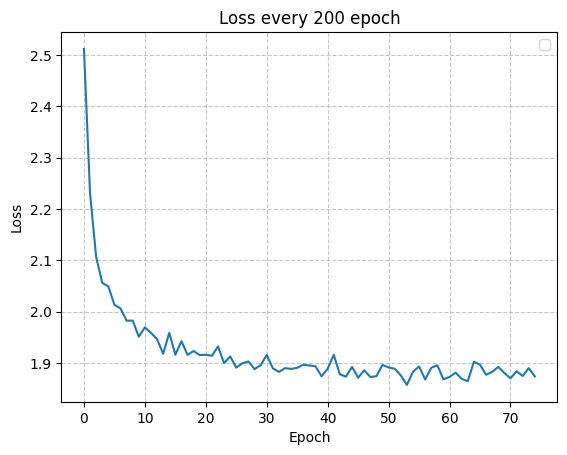

In [ ]:
plt.plot(all_losses_vanilla)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss every %s' %plot_every + ' epoch')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The samples look Shakespeary-styled and the loss reaches a plateau around 1.9 after the training. There are still some inconsistencies we can notice, but the style is catching up and outputs sometimes even come with the right formatting (line break...)

# 3. GRU RNN training

In [ ]:
model = GRU_RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses_gru = []
loss_avg = 0

In [ ]:
for epoch in range(1, n_epochs + 1):

    loss = train(model, *random_training_set_chunky(raw_dataset_shakespeare, dataset_len_shakespeare,chunk_len), chunk_len)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, random.sample(all_characters[36:62],1)[0], 200), '\n')

    if epoch % plot_every == 0:
        all_losses_gru.append(loss_avg / plot_every)
        loss_avg = 0

 49s (5000 33%) 2.0979]
A.
Formy a work and Juill,
Wilish thine your havress.
And be was many liefell himmono hones it one the Prite,
Bear?

MACENO.
[_Ders. Sheath the ento linf heart lady,
Some? And of to molier,
I hope, sid 

 38s (10000 66%) 1.6980]
USTo exishing.

DELO.
But the Tellless we death teath he stand,
On heart vite, drown woriently, arcy, sir, how your John: I wrongue your herchel. I reseep old with not the ears
That did I heep he fory  

 25s (15000 100%) 1.7501]
VIR.
What thy ars'st about in thou thou good you.

SCENE.
By his faumy wour's quinkly, me,
At to must fut powaly, and kind:
If what hardens hences
Junes rans abough father, my for harder a
true my fate 



In [ ]:
print(evaluate(model, 'T', 200))

TOUCHA.
That entage so all Duke;
Of it now? Sucee such morten now a to my rement that the I.
What with true but and my like to from father, in maked lady we callon you did,
Make all the love you, are t


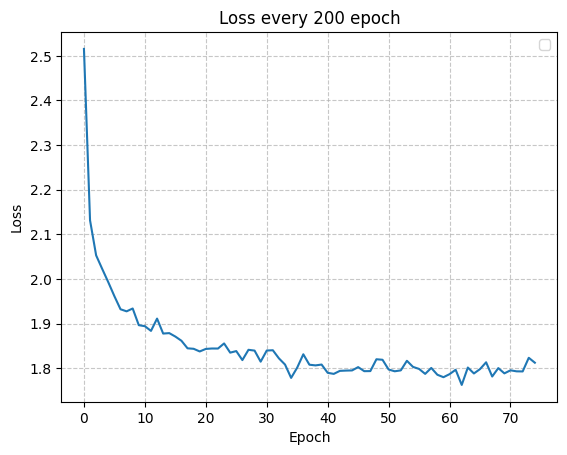

In [ ]:
plt.plot(all_losses_gru)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss every %s' %plot_every + ' epoch')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The final training loss is lower than for the vanilla RNN, and is around 1.8, and the samples are even more realistic: the syntax is more respectful of a Shakespeare drama scene, with characters names in uppercase, line break after the character name for his text and more intelligible sentences.

# 4. Dinosaurs names generation

In [11]:
start_char = 0
replace_list = [("\n"," ")]

raw_dataset_dinos, dataset_len_dinos = read_file('dinos.txt', replace_list, start_char)
raw_dataset_dinos = raw_dataset_dinos.split()

n_epochs = 15000
print_every = 2000
plot_every = 200
hidden_size = 100
n_layers = 1
lr = 0.005

In [12]:
model = GRU_RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

In [13]:
for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set_dino(raw_dataset_dinos)
    loss = train(model, inp, target, len(inp))
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, random.sample(all_characters[36:62],1)[0], random.randint(8,20)), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 23s (2000 13%) 2.3323]
Yunginople 

 43s (4000 26%) 1.0236]
Vironentopanos 

 8s (6000 40%) 1.2254]
Siocitasuc 

 28s (8000 53%) 1.7432]
Zuringosaurusaurusaur 

 47s (10000 66%) 1.5667]
DrochelusaurusKhleri 

 6s (12000 80%) 1.4368]
Cananiasaurusaurusa 

 24s (14000 93%) 1.8108]
RialtianosaurusK 



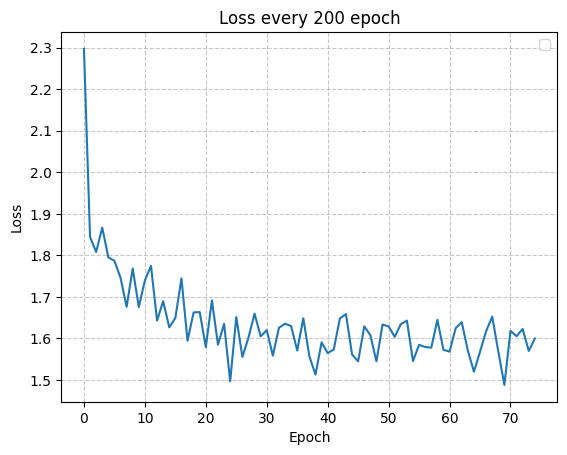

In [14]:
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss every %s' %plot_every + ' epoch')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
print(evaluate(model,'T', random.randint(8,15), temperature=0.5))

Titantosaurus


This dataset being way smaller, with the same number of epoch, the training time is 30x smaller and we manage to have a smaller loss (between 1.5 and 1.6) than for the Shakespeare data. The generated dinosaur names also look pretty realistic. I tried different choices for the temperature and 0.5 gives pretty good names.